In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time, random

In [5]:
class Timer:
    def __init__(self):
        self.CURTIME = 0
    def dtime(self, msg):
        o, self.CURTIME = time.time_ns()/1000-self.CURTIME, time.time_ns()/1000
        tf.print(f"mark: {msg}, time since called: {o}")

In [6]:
class Node(dict):
    bino = lambda x,w: tf.einsum("i->", w*binomial(x))
    def __init__(self, *args, **kwds):
        super(Node, self).__init__(*args, **kwds)
        self.__dict__ = self
    
    def __call__(self, x):
        i = [0,0]
        if not isinstance(x, list):
            x = list(x)
        if isinstance(self.left, int):
            i[0] = x[self.left]
        else:
            i[0] = self.left(x)
        if isinstance(self.right, int):
            i[1] = x[self.right]
        else:
            i[1] = self.right(x)
        return self.op(i, self.weights)
    
    def __getitem__(self, key):
        if key == 0:
            return self.left
        elif key == 1:
            return self.right
        else:
            raise IndexError(f"Tree has only 2 branches, can't get branch {key}")

    def __setitem__(self, key, value):
        if key == 0:
            self.left = value
        elif key == 1:
            self.right = value
        else:
            raise IndexError(f"Tree has only 2 branches,  can't set branch {key}")
    
    def __hash__(self):
        return hash(
            str(hash(self.op))
            +str(hash(self.weights))
            +str(hash(self.left))
            +str(hash(self.right))
        )
    
    def __repr__(self):
        w = self.weights
        eq = f"{w[0]}x^2 + {w[1]}x + {w[2]}xy + {w[3]}y + {w[4]}y^2 + {w[5]}"
        return ' '.join(('( eq:', eq, 'l:', str(self.left), 'r:', str(self.right), ')'))
        


In [7]:
def binomial(x):
    return tf.concat(
        [
            x[0]**2,
            x[0],
            x[0]*x[1],
            x[1],
            x[1]**2,
            1.
        ], 0)

In [18]:
MAX_STEP = 1000
SSF = MAX_STEP/5
timer = Timer()
def gradient_descent_node(test_inputs, test_results, descent_rate, max_grad=1, max_err=10, max_grad_conv=None, assumptions=None):
    
    if assumptions is None:
        assumptions = tf.ones(shape=(6), dtype=tf.float32)
        
    if max_grad_conv is None:
        max_grad_conv = max_grad*1e-3
    
    inputs_bino = tf.TensorArray(tf.float32, size=test_inputs.shape[0])
    for i in tf.range(test_inputs.shape[0]):
        inputs_bino = inputs_bino.write(i, binomial(test_inputs[i]))
    inputs_bino = inputs_bino.stack()

    grad = 1e3+1
    gradp = 0.
    step = 0
    while True:
        weights = tf.Variable([random.random()*assumptions[_] for _ in range(6)], dtype=tf.float32)
        y = tf.einsum("j,ij->i",weights,inputs_bino)
        eps = (y - test_results)
        grad = tf.einsum("i->", eps)
        err = tf.einsum("i->", eps**2)
        if random.random() > 1/np.log(err):
            break
    grad = 1001.
    while (((tf.abs(tf.abs(grad)-tf.abs(gradp)) > max_grad_conv and tf.abs(grad) > max_grad) 
            or err > max_err) and step < MAX_STEP):
        gradp = grad
        y = tf.einsum("j,ij->i",weights,inputs_bino)
        eps = (y - test_results)
        jacobi = tf.einsum("ij->i",eps*tf.transpose(inputs_bino))
        grad = tf.einsum("i->", jacobi)
        scale = 1.5+(SSF-(step%SSF))/(SSF)
        weights.assign_sub(descent_rate*scale*jacobi*assumptions/(tf.norm(inputs_bino)**2))
        step+=1
        err = tf.einsum("i->", eps**2)
    return {"weights": weights, "error": err}

In [54]:
def regress(goal, 
            arg_constraints, 
            n_points, 
            assumptions=None,
            keep=3,
            err_goal=1,
            batch_size=15
           ):
    """
    goal: function [int] -> int
    arg_constraints: [[left bound: int, right bound: int]]
    """
    input_vectors = []
    layer_structure = []
    nargs = len(arg_constraints)
    for a in arg_constraints:
        input_vectors.append(tf.constant([random.random()*(a[1]-a[0])+a[0] for _ in range(n_points)], dtype=tf.float32))
    
    out = tf.concat(list(map(goal, tf.transpose(tf.stack(input_vectors)))), 0)
    
    err_p = err_goal+2
    error = err_goal+1
    
    batch = 0
    
    while np.abs(error) > err_goal and (np.abs(error) < np.abs(err_p) or batch == 1):

        err_p = error
    
        nodes = []
        batch += 1
        inputs = list(set(list(range(nargs))+list(range(len(input_vectors)-keep, len(input_vectors)))))
        i = 0
        for left in inputs:
            for right in inputs:
                if left == right:
                    continue

                inp = tf.transpose(tf.stack([input_vectors[left], input_vectors[right]]))

                g = gradient_descent_node(test_inputs=tf.constant(inp, dtype=tf.float32),
                                          test_results=out,
                                          descent_rate=1e-1,
                                          max_grad=1e-1,
                                          max_err=1,
                                          assumptions=assumptions)

                nodes.append(
                    Node(
                        left=left, 
                        right=right, 
                        op=Node.bino, 
                        weights=g["weights"], 
                        err=g["error"]
                    ))

                print(f"node {i} batch {batch} err {g['error']}")
                i += 1

        nodes.sort(key=lambda x: np.abs(x.err))
        error = nodes[0].err
        nodes = nodes[:keep]

        layer_structure.append([])
        for n in nodes:
            if n.right >= nargs:
                n.right = layer_structure[(n.right-nargs)//keep][(n.right-nargs)%keep]
            if n.left >= nargs:
                n.left = layer_structure[(n.left-nargs)//keep][(n.left-nargs)%keep]
            input_vectors.append(tf.concat([n(x) for x in inp], 0))
            layer_structure[-1].append(n)
            
    if np.abs(error) > np.abs(err_p):
        layer_structure = layer_structure[:-1]
    
    return layer_structure

In [58]:
t_f = lambda x: x[1]**3+5
t_p = [(random.random(), random.random()*np.pi) for _ in range(100)]
t_y = list(map(t_f,t_p))

bino = lambda x,w: tf.einsum("i->", w*binomial(x))
ass = tf.constant([1,1,1,1,1,1], dtype=tf.float32)
o = regress(goal = t_f, arg_constraints=[[-10,10], [-5, 5]], n_points=1000, err_goal=1e-3)

o

node 0 batch 1 err 764210.625
node 1 batch 1 err 779380.625
node 2 batch 1 err 779262.5625
node 3 batch 1 err 341680.78125
node 4 batch 1 err 786793.0625
node 5 batch 1 err 342346.71875
node 0 batch 2 err 797868.1875
node 1 batch 2 err 2092881.0
node 2 batch 2 err 2129778.75
node 3 batch 2 err 645953.75
node 4 batch 2 err 791538.5
node 5 batch 2 err 1610206.0
node 6 batch 2 err 2650242.75
node 7 batch 2 err 1499098.125
node 8 batch 2 err 2023884.875
node 9 batch 2 err 739782.5625
node 10 batch 2 err 426007.65625
node 11 batch 2 err 1440109.375
node 12 batch 2 err 2281011.75
node 13 batch 2 err 554425.4375
node 14 batch 2 err 825140.875
node 15 batch 2 err 680714.9375
node 16 batch 2 err 821039.0
node 17 batch 2 err 1981523.5
node 18 batch 2 err 234934.921875
node 19 batch 2 err 428322.53125
node 0 batch 3 err 785256.5
node 1 batch 3 err 143774600658944.0
node 2 batch 3 err 12370727403520.0
node 3 batch 3 err 19869389029376.0
node 4 batch 3 err 802229.5625
node 5 batch 3 err 15302517587

[[( eq: 0.5359695553779602x^2 + 7.365067005157471x + -0.3592906892299652xy + 7.332671642303467y + 0.17946332693099976y^2 + 1.4967371225357056 l: 1 r: -1 ),
  ( eq: 0.01706842891871929x^2 + 7.635113716125488x + 0.3036574125289917xy + 7.060931205749512y + 0.051305290311574936y^2 + 1.2630306482315063 l: -1 r: 1 ),
  ( eq: 0.01205016952008009x^2 + -0.14928856492042542x + 0.0008086206507869065xy + 7.557666301727295y + 0.4713124930858612y^2 + 0.9128885865211487 l: 0 r: 1 )],
 [( eq: -0.05883655697107315x^2 + 0.13310809433460236x + 0.17732399702072144xy + 0.07229960709810257y + -0.07217828929424286y^2 + 0.4711017608642578 l: ( eq: 0.01205016952008009x^2 + -0.14928856492042542x + 0.0008086206507869065xy + 7.557666301727295y + 0.4713124930858612y^2 + 0.9128885865211487 l: 0 r: 1 ) r: ( eq: 0.5359695553779602x^2 + 7.365067005157471x + -0.3592906892299652xy + 7.332671642303467y + 0.17946332693099976y^2 + 1.4967371225357056 l: 1 r: -1 ) ),
  ( eq: -0.015821347013115883x^2 + 0.5941985845565796x + 0

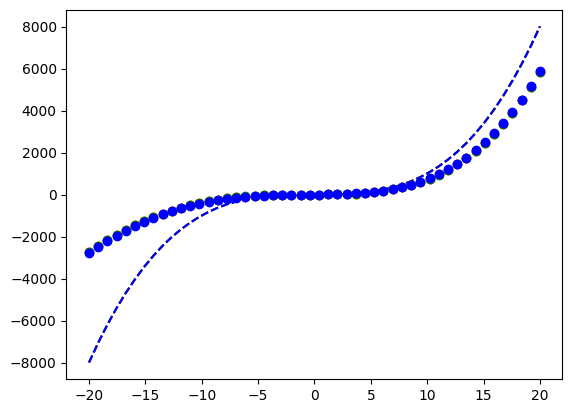

In [61]:
from matplotlib import pyplot as plt

n=o[-1][0]

r_x = np.linspace(-20, 20)
r_y1 = [t_f([p, 0]) for p in r_x]
r_y2 = [t_f([p, 5]) for p in r_x]
r_y3 = [t_f([p, -5]) for p in r_x]
n_y1 = [n(tf.constant([p, 0], dtype=tf.float32)) for p in r_x]
n_y2 = [n(tf.constant([p, 5], dtype=tf.float32)) for p in r_x]
n_y3 = [n(tf.constant([p, -5], dtype=tf.float32)) for p in r_x]

plt.plot(
    r_x, r_y1, "r--",
    r_x, r_y2, "g--",
    r_x, r_y3, "b--",
    r_x, n_y1,  "ro",
    r_x, n_y2,  "go",
    r_x, n_y3,  "bo",
)

In [ ]:
np.sqrt(2.5/(1*))